<a href="https://colab.research.google.com/github/aishwaryamallampati/BTech-IIITDM/blob/master/squad_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install langdetect
# importing all necessary files
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import json
import re
import nltk
import csv


from langdetect import detect
from pickle import dump,load

import tensorflow as tf
import sys
import datetime
import os
import six

from collections import Counter
import string
import re
import sys

from google.colab import files
from keras.preprocessing.sequence import pad_sequences
from keras.layers import recurrent
from keras import layers
from keras.models import Model

In [0]:
#Run this cell two times to load train-v2.0.json and dev-v2.0.json
uploaded = files.upload()

Saving train-v2.0.json to train-v2.0.json


In [0]:
train = pd.read_json("train-v2.0.json")
dev = pd.read_json("dev-v2.0.json")
print(train.shape)
print(dev.shape)

print(train.head())

(442, 2)
(35, 2)
  version                                               data
0    v2.0  {'title': 'Beyoncé', 'paragraphs': [{'qas': [{...
1    v2.0  {'title': 'Frédéric_Chopin', 'paragraphs': [{'...
2    v2.0  {'title': 'Sino-Tibetan_relations_during_the_M...
3    v2.0  {'title': 'IPod', 'paragraphs': [{'qas': [{'qu...
4    v2.0  {'title': 'The_Legend_of_Zelda:_Twilight_Princ...


In [0]:
# getting train data and dev data into csv file

contexts = []
questions = []
answers_text = []
answers_start = []
title = []
for i in range(train.shape[0]):
    topic = train.data[i]['paragraphs']
    title_ = train.data[i]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                answers_start.append(q_a['answers'][0]['answer_start']) 
                answers_text.append(q_a['answers'][0]['text'])
            else:
                answers_start.append(None)
                answers_text.append(None)
            contexts.append(sub_para['context'])
            title.append(title_)
            
# test data

test_contexts = []
test_questions = []
test_answers_text = []
test_answers_start = []
test_title = []
for i in range(dev.shape[0]):
    topic = dev.data[i]['paragraphs']
    title_ = dev.data[i]['title']
    for sub_para in topic:
        for q_a in sub_para['qas']:
            test_questions.append(q_a['question'])
            if len(q_a['answers'])>0 :
                test_answers_start.append(q_a['answers'][0]['answer_start']) 
                test_answers_text.append(q_a['answers'][0]['text'])
            else:
                test_answers_start.append(None)
                test_answers_text.append(None)
            test_contexts.append(sub_para['context'])
            test_title.append(title_)

In [0]:
train = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "answer": answers_text,'title':title})
train.dropna(inplace=True)
train.head()

,context,question,answer_start,answer,title
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269.0,in the late 1990s,Beyoncé
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207.0,singing and dancing,Beyoncé
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526.0,2003,Beyoncé
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166.0,"Houston, Texas",Beyoncé
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276.0,late 1990s,Beyoncé


In [0]:
dev = pd.DataFrame({"context":test_contexts, "question": test_questions, "answer_start": test_answers_start, "answer": test_answers_text,'title':test_title})
dev.dropna(inplace=True)

In [0]:
def decontracted(phrase):
    """
    This function remooves punctuation from given sentence.
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    # string operation
    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = phrase.replace('\\n', ' ')

    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase.lower())
    
    return phrase


def tokenize(sentence):
    """
    Returns tokenised words.
    """
    return nltk.word_tokenize(sentence)

def answer_span(context,ans):
    """
    This funtion returns anwer span start index and end index.
    """
    ans_token = tokenize(ans)
    con_token = tokenize(context)
    ans_len = len(ans_token)
    
    if ans_len!=0 and ans_token[0] in con_token:
    
        indices = [i for i, x in enumerate(con_token) if x == ans_token[0]]
        try:

            if(len(indices)>1):
                start = [i for i in indices if (con_token[i:i+ans_len] == ans_token) ]
                end = start[0] + ans_len - 1
                return start[0],end

            else:
                start = con_token.index(ans_token[0])
                end = start + ans_len - 1
                return start,end
        except:
            return -1,-1
    else:
        return -1,-1

In [0]:
# for train data
from tqdm import tqdm
preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(train["context"].values):
    sent = decontracted(str(sentance))
    preprocessed_context.append(sent.strip())
    
train["clean_context"] = preprocessed_context
print(preprocessed_context[0])
        


100%|██████████| 86821/86821 [00:04<00:00, 18914.07it/s]

beyonc giselle knowles carter bi j nse bee yon say born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of r b girl group destiny is child managed by her father mathew knowles the group became one of the world is best selling girl groups of all time their hiatus saw the release of beyonc is debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 number one singles crazy in love and baby boy


In [0]:
# for dev data
from tqdm import tqdm
dev_preprocessed_context = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["context"].values):
    sent = decontracted(str(sentance))
    dev_preprocessed_context.append(sent.strip())
    
dev["clean_context"] = dev_preprocessed_context

100%|██████████| 5928/5928 [00:00<00:00, 17253.65it/s]


In [0]:
# for train data

from tqdm import tqdm
preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(train["question"].values):
    sent = decontracted(str(sentance))
    preprocessed_question.append(sent.strip())
    
train["clean_question"] = preprocessed_question

100%|██████████| 86821/86821 [00:01<00:00, 74144.17it/s]


In [0]:
# for dev data
    
from tqdm import tqdm
dev_preprocessed_question = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["question"].values):
  sent = decontracted(str(sentance))
  dev_preprocessed_question.append(sent.strip())

dev["clean_question"] = dev_preprocessed_question

100%|██████████| 5928/5928 [00:00<00:00, 69554.05it/s]


In [0]:
# for train data
    
preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(train["answer"].values):
  sent = decontracted(str(sentance))
  preprocessed_answer.append(sent.strip())
    
    
train["clean_answer"] = preprocessed_answer

100%|██████████| 86821/86821 [00:00<00:00, 88094.62it/s]


In [0]:
# for dev data
    
dev_preprocessed_answer = []
# tqdm is for printing the status bar
for sentance in tqdm(dev["answer"].values):
  sent = decontracted(str(sentance))
  dev_preprocessed_answer.append(sent.strip())
    
dev["clean_answer"] = dev_preprocessed_answer

100%|██████████| 5928/5928 [00:00<00:00, 85952.24it/s]


In [0]:
# function for language detction

def get_language(string):
    
    """
    This function returns the language of string. Uses Textblob which internally uses google API. 
    
    This creates problem when you have to check for too many values.
    
    You will get --> 'HTTPError: HTTP Error 429: Too Many Requests'
    
    @return - language
    
    """
    return TextBlob(string).detect_language()


def language(string):
    """
    Not as accurate as TextBlob but gets our work done.
    
    @return - language
    
    """
    return detect(string)

In [0]:
# for train data
# this cell takes longer time 
train["language"] = train["clean_context"].apply(language)
print(np.unique(train["language"]))

['en' 'nl']


In [0]:
# for dev data

dev["language"] = dev["clean_context"].apply(language)
print(np.unique(dev["language"]))

['en']


In [0]:
train = train[train["language"] == 'en']
print(train.shape)

dev = dev[dev["language"] == 'en']
print(dev.shape)
print(train.info())

(86820, 9)
(5928, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 86820 entries, 0 to 130050
Data columns (total 9 columns):
context           86820 non-null object
question          86820 non-null object
answer_start      86820 non-null float64
answer            86820 non-null object
title             86820 non-null object
clean_context     86820 non-null object
clean_question    86820 non-null object
clean_answer      86820 non-null object
language          86820 non-null object
dtypes: float64(1), object(8)
memory usage: 6.6+ MB
None


In [0]:
nltk.download('punkt')
ans_span = []
for i in range(len(train)):
    s,e = answer_span(train["clean_context"].iloc[i],train["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

train["ans_span"] = ans_span

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
number of answer not matching context :-  194


In [0]:
ans_span = []
for i in range(len(dev)):
    s,e = answer_span(dev["clean_context"].iloc[i],dev["clean_answer"].iloc[i])
    ans_span.append((s,e))
    
print("number of answer not matching context :- ",ans_span.count((-1,-1)))

dev["ans_span"] = ans_span

number of answer not matching context :-  6


In [0]:
print(train.shape)
print(dev.shape)

(86820, 10)
(5928, 10)


In [0]:
train = train[train["ans_span"] != (-1,-1)]
dev = dev[dev["ans_span"] != (-1,-1)]
print(train.shape)
print(dev.shape)

(86626, 10)
(5922, 10)


In [0]:
# adding context_length ,question_length and answer_length features for eda
train["context_length"] = train["clean_context"].apply(lambda x:len(x.split()))
train["question_length"] = train["clean_question"].apply(lambda x:len(x.split()))
train["answer_length"] = train["clean_answer"].apply(lambda x:len(x.split()))

dev["context_length"] = dev["clean_context"].apply(lambda x:len(x.split()))
dev["question_length"] = dev["clean_question"].apply(lambda x:len(x.split()))
dev["answer_length"] = dev["clean_answer"].apply(lambda x:len(x.split()))

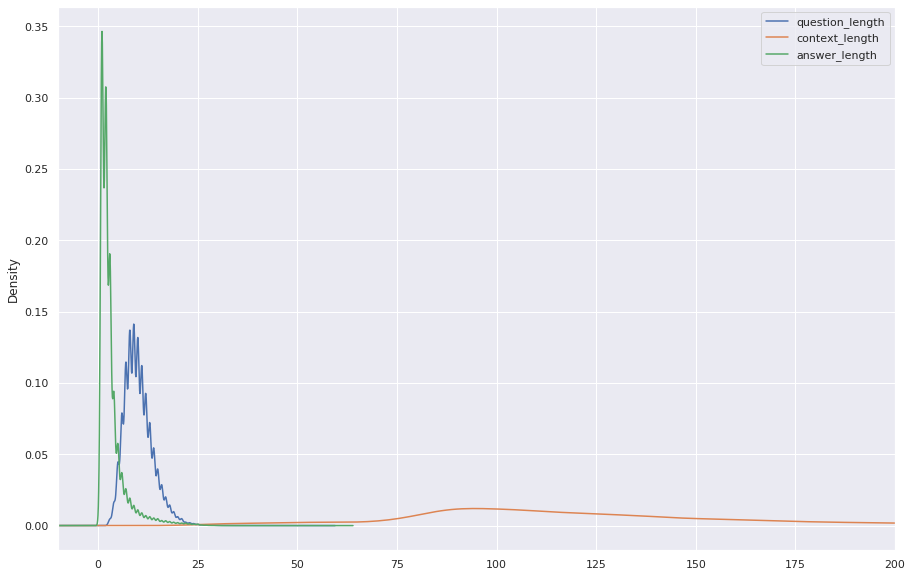

In [0]:
sns.set()
tf = train[["question_length","context_length","answer_length"]]
tf.plot.kde(figsize=(15,10),xlim=(-10,200))

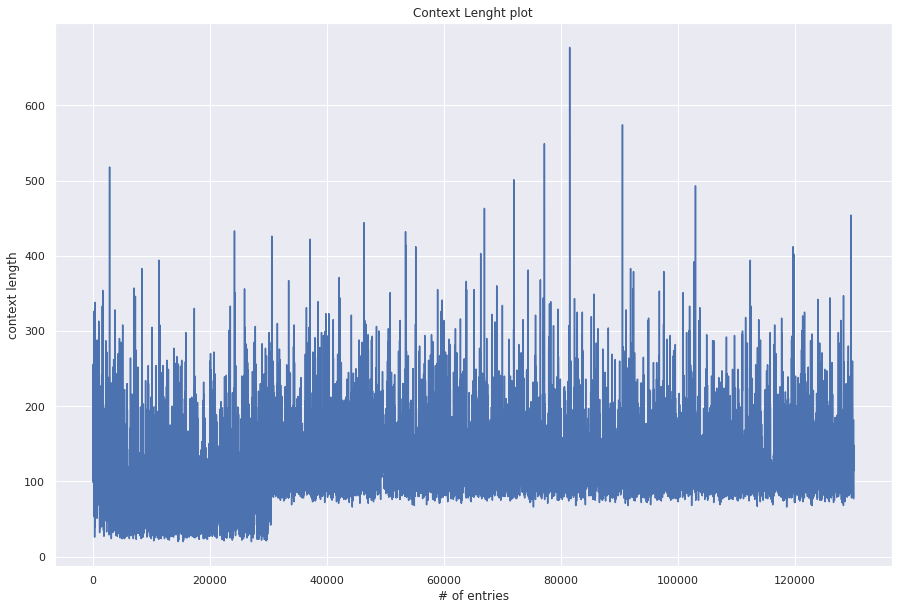

In [0]:
#Train Context length
plt.figure(figsize=(15,10))
plt.plot(train["context_length"])
plt.xlabel("# of entries")
plt.ylabel("context length")
plt.yticks(range(0,700,100))
plt.title("Context Lenght plot")
plt.show()

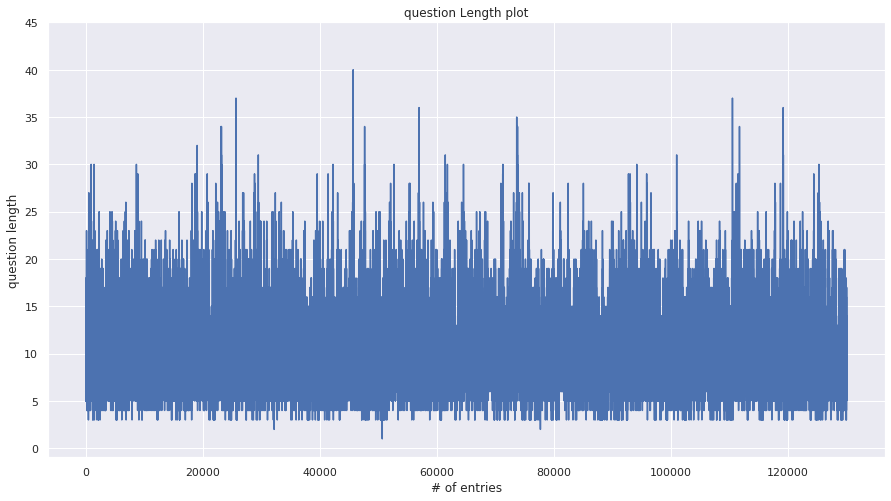

In [0]:
#Train Question Length 
plt.figure(figsize=(15,8))
plt.plot(train["question_length"])
plt.xlabel("# of entries")
plt.ylabel("question length")
plt.yticks(range(0,50,5))
plt.title("question Length plot")
plt.show()

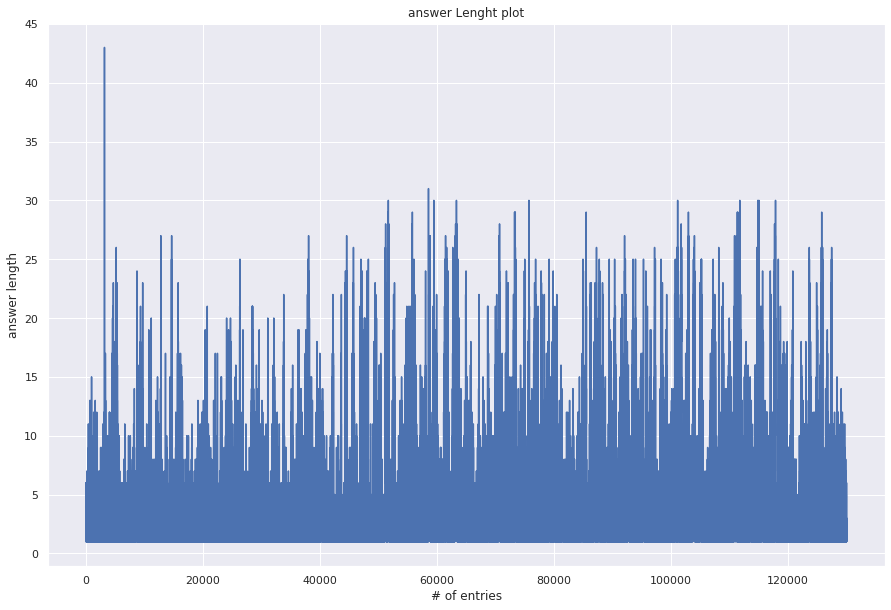

In [0]:
#Answer lenght plot
plt.figure(figsize=(15,10))
plt.plot(train["answer_length"])
plt.xlabel("# of entries")
plt.ylabel("answer length")
plt.yticks(range(0,50,5))
plt.title("answer Lenght plot")
plt.show()

In [0]:
train["answer_length"].describe()

count    86626.000000
mean         3.303927
std          3.454053
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         43.000000
Name: answer_length, dtype: float64

In [0]:
train = train[train["answer_length"] == 1]
dev = dev[dev["answer_length"] == 1]
print(train.shape)
print(dev.shape)

(26266, 13)
(1769, 13)


In [0]:
train_fullset = train
dev_fullset = dev
print(train_fullset.shape)
print(dev_fullset.shape)

In [0]:
train = train_fullset.head(5000)
dev = dev_fullset.head(1000)
print(train.shape)
print(dev.shape)

(1000, 13)
(200, 13)


In [0]:
def tokenization(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split(r'(\W+)', sent) if x.strip()]

In [0]:
train_data = []
for i in range(train.shape[0]):
    train_data.append([])
    train_data[i].append(tokenization(train['clean_context'].iloc[i]))
    train_data[i].append(tokenization(train['clean_question'].iloc[i]))
    train_data[i].append((train['clean_answer'].iloc[i]))

In [0]:
dev_data = []
for i in range(dev.shape[0]):
    dev_data.append([])
    dev_data[i].append(tokenization(dev['clean_context'].iloc[i]))
    dev_data[i].append(tokenization(dev['clean_question'].iloc[i]))
    dev_data[i].append((dev['clean_answer'].iloc[i]))

In [0]:
vocab = set()
for context, question, answer in train_data + dev_data:
    vocab |= set(context + question + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
story_maxlen = max(map(len, (x for x, _, _ in train_data + dev_data)))
query_maxlen = max(map(len, (x for _, x, _ in train_data + dev_data)))

In [0]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    xs = []
    xqs = []
    ys = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        xs.append(x)
        xqs.append(xq)
        ys.append(y)
    return (pad_sequences(xs, maxlen=story_maxlen),
            pad_sequences(xqs, maxlen=query_maxlen), np.array(ys))

In [0]:
x, xq, y = vectorize_stories(train_data, word_idx, story_maxlen, query_maxlen)
tx, txq, ty = vectorize_stories(dev_data, word_idx, story_maxlen, query_maxlen)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(x.shape))
print('xq.shape = {}'.format(xq.shape))
print('y.shape = {}'.format(y.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

vocab = ['0', '00', '000', '007', '00s', '01', '010', '02', '03', '04', '05', '06', '079', '08', '09', '1', '10', '100', '1000', '1013', '1016', '1018', '104', '1041', '105', '1050s', '1051', '1060s', '1064', '1066', '1072', '1073', '1074', '108', '1081', '1082', '1085', '1096', '1097', '10th', '11', '110', '1107', '1115', '112', '1125', '113', '115', '1169', '118', '1182', '1185', '119', '1191', '11th', '12', '120', '1200', '1203', '122', '1234', '1235', '1236', '1240', '1241', '1245', '1246', '1247', '1251', '1253', '1260', '1260s', '1271', '1279', '128', '1280', '1283', '1294', '12th', '13', '1302', '132', '1340', '1357', '1358', '136', '1364', '1368', '1371', '1378', '1382', '1383', '1384', '1391', '13th', '14', '1402', '1403', '1405', '1407', '1413', '1414', '1415', '1418', '1419', '1424', '1425', '1427', '143', '1430s', '1434', '1435', '144', '1446', '1474', '1475', '1498', '14th', '15', '150', '1507', '1518', '152', '1523', '1524', '1525', '1527', '1537', '154', '1543', '1565', 

In [0]:
RNN = recurrent.LSTM
EMBED_HIDDEN_SIZE = 50
SENT_HIDDEN_SIZE = 100
QUERY_HIDDEN_SIZE = 100
BATCH_SIZE = 32
EPOCHS = 1
print('RNN / Embed / Sent / Query = {}, {}, {}, {}'.format(RNN,
                                                           EMBED_HIDDEN_SIZE,
                                                           SENT_HIDDEN_SIZE,
                                                           QUERY_HIDDEN_SIZE))

RNN / Embed / Sent / Query = <class 'keras.layers.recurrent.LSTM'>, 50, 100, 100


In [0]:
print('Build model...')

sentence = layers.Input(shape=(story_maxlen,), dtype='int32')
encoded_sentence = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(sentence)
encoded_sentence = RNN(SENT_HIDDEN_SIZE)(encoded_sentence)

question = layers.Input(shape=(query_maxlen,), dtype='int32')
encoded_question = layers.Embedding(vocab_size, EMBED_HIDDEN_SIZE)(question)
encoded_question = RNN(QUERY_HIDDEN_SIZE)(encoded_question)

merged = layers.concatenate([encoded_sentence, encoded_question])
preds = layers.Dense(vocab_size, activation='softmax')(merged)

model = Model([sentence, question], preds)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Build model...




In [0]:
print('Training')
model.fit([x, xq], y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.05)

Training
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 950 samples, validate on 50 samples
Epoch 1/1





950/950 [==============================] - 39s 41ms/step - loss: 8.9133 - acc: 0.0084 - val_loss: 9.1529 - val_acc: 0.0000e+00


In [0]:
print('Evaluation')
loss, acc = model.evaluate([tx, txq], ty,
                           batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Evaluation
200/200 [==============================] - 2s 12ms/step
Test loss / test accuracy = 8.9944 / 0.0050
